# 3 Modeling

**Team 1:** John Chen, Mendelina Lopez, and Katie Hu

The focus of this notebook is to model and deploy an application.
  
<font color = red > **NOTICE:** </font> This study uses Twitter data to detect hate speech and offensive language. The content can be triggering due to the nature of the study with text consisting of racist, homophobic, sexist, and offensive language.
<br>
<br>  
***

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
# Import Dependencies

# Libraries For Data Preparation
import os
import re
import sys
import pandas as pd
import numpy as np
import nltk
import contractions
import string
from collections import defaultdict, Counter
from string import punctuation
from nltk import pos_tag
from nltk.tokenize import RegexpTokenizer, word_tokenize, TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tabulate import tabulate
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split

# For Graphs
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# Modeling
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from sklearn.naive_bayes import BernoulliNB
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# !pip install contractions

In [4]:
# Set Path to EDA Analysis Phase II
modeling_path = '../Image/Modeling/'

# Read in Data
prepared_data = pd.read_csv('../Data/prepared_data.csv', index_col = [0])
prepared_data.head()

In [5]:
# prepared_data = pd.read_csv('/content/sample_data/prepared_data.csv', index_col = [0])
# prepared_data.head()

,tweet,tokens,clean_tweet,class,tweet_length,sentiment_scores,sentiment,compound_score
0,!!! RT @mayasolovely: As a woman you shouldn't...,"['@mayasolovely', 'woman', 'complain', 'cleani...",@mayasolovely woman complain cleaning house ...,0,9,"{'neg': 0.238, 'neu': 0.762, 'pos': 0.0, 'comp...",negative,-0.3612
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,"['@mleew', 'boy', 'dat', 'coldtyga', 'dwn', 'b...",@mleew boy dat coldtyga dwn bad cuffin dat h...,1,11,"{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'comp...",negative,-0.5423
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,"['@urkindofbrand', 'dawg', '@sbabylife', 'ever...",@urkindofbrand dawg @sbabylife ever fuck bi...,1,10,"{'neg': 0.761, 'neu': 0.239, 'pos': 0.0, 'comp...",negative,-0.9423
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,"['@cganderson', '@vivabased', 'look', 'like', ...",@cganderson @vivabased look like tranny,1,5,"{'neg': 0.0, 'neu': 0.615, 'pos': 0.385, 'comp...",positive,0.3612
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,"['@shenikarobes', 'shit', 'hear', 'might', 'tr...",@shenikarobes shit hear might true might fak...,1,10,"{'neg': 0.43, 'neu': 0.407, 'pos': 0.163, 'com...",negative,-0.6808


In [6]:
df2 = prepared_data.copy()

In [7]:
# Set the Label to be Numerical
label = df2['sentiment']
sentiment_ordering = ['negative', 'neutral', 'positive']
y = label.apply(lambda x: sentiment_ordering.index(x))

In [8]:
# Input column
X = df2['clean_tweet']

In [9]:
# Splitting of Data
X_train, X_test, y_train, y_test = train_test_split(df2['clean_tweet'], y, test_size = .15, stratify = y, random_state = 1025)

# Use TfidfVectorizer to convert text to a matrix of TF-IDF features
vec = TfidfVectorizer(strip_accents = 'unicode', analyzer = 'word', ngram_range = (1,3))
vec.fit(X_train)
X_train = vec.transform(X_train)
X_test = vec.transform(X_test)

In [33]:
# Model Testing of Multinomial Naive-Bayes
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)
y_predNB = NB_model.predict(X_test)
cf = classification_report(y_test, y_predNB)
acc = accuracy_score(y_test, y_predNB)
nb_multi_probs = NB_model.predict_proba(X_test)[:, 1]
print("Accuracy of the classifier: ", round((acc*100), 2),'%')
print("Confusion matrix is :\n",metrics.confusion_matrix(y_test,y_predNB))
print("Classification Report is :\n", cf)

Accuracy of the classifier:  60.65 %
Confusion matrix is :
 [[2212    0    1]
 [ 673    7    3]
 [ 786    0   36]]
Classification Report is :
               precision    recall  f1-score   support

           0       0.60      1.00      0.75      2213
           1       1.00      0.01      0.02       683
           2       0.90      0.04      0.08       822

    accuracy                           0.61      3718
   macro avg       0.83      0.35      0.29      3718
weighted avg       0.74      0.61      0.47      3718



In [34]:
# Model Testing of Bernoulli Naive-Bayes
classifier = BernoulliNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred)
nb_probs = classifier.predict_proba(X_test)[:, 1]
print("Accuracy of the classifier: ", round((acc*100), 2),'%')
print("Confusion matrix is :\n",metrics.confusion_matrix(y_test,y_pred))
print("Classification report: \n" ,metrics.classification_report(y_test,y_pred))

Accuracy of the classifier:  59.71 %
Confusion matrix is :
 [[2213    0    0]
 [ 682    0    1]
 [ 815    0    7]]
Classification report: 
               precision    recall  f1-score   support

           0       0.60      1.00      0.75      2213
           1       0.00      0.00      0.00       683
           2       0.88      0.01      0.02       822

    accuracy                           0.60      3718
   macro avg       0.49      0.34      0.25      3718
weighted avg       0.55      0.60      0.45      3718



In [35]:
# XGBoost Classifier Model
xgb_model=xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc' )

xgb_model_vectorizer = xgb_model.fit(X_train, y_train)
y_pred = xgb_model_vectorizer.predict(X_test)
acc = accuracy_score(y_test, y_pred)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
print("Accuracy of the classifier: ", round((acc*100), 2),'%')
print("Confusion matrix is :\n",metrics.confusion_matrix(y_test,y_pred))
print("Classification report: \n" ,metrics.classification_report(y_test,y_pred))

Accuracy of the classifier:  79.94 %
Confusion matrix is :
 [[1860  235  118]
 [  23  639   21]
 [ 139  210  473]]
Classification report: 
               precision    recall  f1-score   support

           0       0.92      0.84      0.88      2213
           1       0.59      0.94      0.72       683
           2       0.77      0.58      0.66       822

    accuracy                           0.80      3718
   macro avg       0.76      0.78      0.75      3718
weighted avg       0.83      0.80      0.80      3718



In [32]:
# Modeling of Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)
lr_acc = accuracy_score(lr_predict, y_test)
lr_probs = lr.predict_proba(X_test)[:, 1]
print("Accuracy of the classifier: ", round((lr_acc*100), 2),'%')
print("Confusion matrix is :\n",metrics.confusion_matrix(y_test,lr_predict))
print("Classification report: \n" ,metrics.classification_report(y_test,lr_predict))

Accuracy of the classifier:  83.24 %
Confusion matrix is :
 [[2052   77   84]
 [ 144  483   56]
 [ 193   69  560]]
Classification report: 
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      2213
           1       0.77      0.71      0.74       683
           2       0.80      0.68      0.74       822

    accuracy                           0.83      3718
   macro avg       0.81      0.77      0.79      3718
weighted avg       0.83      0.83      0.83      3718



In [15]:
# Hypertune the Logistic Regression Model
param_grid = {'C':[100, 10, 1.0, 0.1, 0.01], 'solver' :['newton-cg', 'lbfgs','liblinear']}
grid = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
grid.fit(X_train, y_train)
print("Best Cross validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best Cross validation score: 0.85
Best parameters:  {'C': 100, 'solver': 'lbfgs'}


In [16]:
# Hypertuned Logistic Regression Model Results
lgrid_pred = grid.predict(X_test)
lgrid_acc = accuracy_score(lgrid_pred, y_test)
print("Accuracy of the classifier: ", round((lgrid_acc*100), 2),'%')
print("Confusion matrix is :\n",metrics.confusion_matrix(y_test,lgrid_pred))
print("Classification report: \n" ,metrics.classification_report(y_test,lgrid_pred))

Accuracy of the classifier:  86.79 %
Confusion matrix is :
 [[2048   70   95]
 [  74  538   71]
 [ 123   58  641]]
Classification report: 
               precision    recall  f1-score   support

           0       0.91      0.93      0.92      2213
           1       0.81      0.79      0.80       683
           2       0.79      0.78      0.79       822

    accuracy                           0.87      3718
   macro avg       0.84      0.83      0.83      3718
weighted avg       0.87      0.87      0.87      3718



In [17]:
# Additional Preprocessing for LSTM Model

# Tokenize preprocessing for LSTM model
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_n = tokenizer.texts_to_sequences(X)

# Pad the sequences for same length
maxlen = 120
X_n = pad_sequences(X_n, maxlen=maxlen)

# num of classes
num_classes = len(sentiment_ordering)

# Split Data
X_train_n, X_test_n, y_train, y_test = train_test_split(X_n, y, test_size = .15, stratify = y, random_state = 1025)

# Add Early Stopping
early_stop = EarlyStopping(monitor="val_loss",patience=5,verbose=True)

# Convert the test target labels to one-hot encoded vectors
y_train_n = to_categorical(y_train, 3)
y_test_n = to_categorical(y_test, 3)

In [18]:
# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=maxlen))
model.add(LSTM(100))
model.add(Dense(128, activation='relu'))
model.add(Dense(units=num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 100)          3041600   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 128)               12928     
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 3,135,315
Trainable params: 3,135,315
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Train the LSTM model
batch_size = 32
epochs = 10
model.fit(X_train_n, y_train_n, batch_size=batch_size, epochs=epochs, validation_data=(X_test_n, y_test_n), callbacks=[early_stop], validation_split=0.15)

Epoch 1/10
659/659 [==============================] - 66s 97ms/step - loss: 0.5137 - accuracy: 0.7982 - val_loss: 0.3627 - val_accuracy: 0.8798
Epoch 2/10
659/659 [==============================] - 64s 97ms/step - loss: 0.2036 - accuracy: 0.9317 - val_loss: 0.3354 - val_accuracy: 0.8868
Epoch 3/10
659/659 [==============================] - 64s 97ms/step - loss: 0.1024 - accuracy: 0.9643 - val_loss: 0.3600 - val_accuracy: 0.8806
Epoch 4/10
659/659 [==============================] - 64s 97ms/step - loss: 0.0630 - accuracy: 0.9793 - val_loss: 0.3608 - val_accuracy: 0.8932
Epoch 5/10
659/659 [==============================] - 63s 96ms/step - loss: 0.0396 - accuracy: 0.9872 - val_loss: 0.4576 - val_accuracy: 0.8800
Epoch 6/10
659/659 [==============================] - 63s 96ms/step - loss: 0.0293 - accuracy: 0.9904 - val_loss: 0.4577 - val_accuracy: 0.8819
Epoch 7/10
659/659 [==============================] - 63s 96ms/step - loss: 0.0174 - accuracy: 0.9944 - val_loss: 0.5443 - val_accuracy:

In [20]:
# Evaluate the LSTM model
loss, accuracy = model.evaluate(X_test_n, y_test_n, batch_size=batch_size)
y_pred_nn = model.predict(X_test_n)
lgrid_pred_nn = np.argmax(y_pred_nn, axis=1) 

confusion_matrix = metrics.confusion_matrix(y_test_n.argmax(axis=1), lgrid_pred_nn)
classification_report = metrics.classification_report(y_test_n.argmax(axis=1), lgrid_pred_nn)

print("Confusion matrix is:\n", confusion_matrix)
print("Classification report:\n", classification_report)
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")

117/117 [==============================] - 3s 23ms/step
Confusion matrix is:
 [[2064   50   99]
 [  57  560   66]
 [  73   37  712]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94      2213
           1       0.87      0.82      0.84       683
           2       0.81      0.87      0.84       822

    accuracy                           0.90      3718
   macro avg       0.87      0.87      0.87      3718
weighted avg       0.90      0.90      0.90      3718

Test loss: 0.5443, Test accuracy: 0.8973


In [21]:
# Save LSTM Model

# Save the model in h5 format
model.save('content/drive/MyDrive/Colab Notebooks/model.h5')

# Convert the model to JSON format
model_json = model.to_json()

# Specify the path where you want to save the JSON file
json_file_path = '/content/drive/MyDrive/Colab Notebooks/lstm.json'

# Save the JSON data to the file
with open(json_file_path, 'w') as json_file:
    json_file.write(model_json)

print("Model has been saved as a JSON file in your Google Drive.")

Model has been saved as a JSON file in your Google Drive.


In [22]:
# Hypertuning the LSTM Model

# Build the LSTM model function for RandomizedSearchCV
def build_lstm_model(embedding_dim, lstm_units, dense_units):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=maxlen))
    model.add(LSTM(units=lstm_units))
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dense(units=num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

lstm_model = KerasClassifier(build_fn=build_lstm_model, verbose=0)

# Define the hyperparameters to search
param_distributions = {
    'embedding_dim': [50, 100, 200],
    'lstm_units': [50, 100, 150],
    'dense_units': [64, 128, 256]
}

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

random_search = RandomizedSearchCV(estimator=lstm_model, param_distributions=param_distributions, cv=3, n_iter=5, random_state=1025)
random_search_result = random_search.fit(X_train_n, y_train_n, validation_data=(X_test_n, y_test_n), validation_split=0.15, callbacks=[early_stop])

# Print the best hyperparameters and accuracy
print("Best: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))

Best: 0.865654 using {'lstm_units': 150, 'embedding_dim': 200, 'dense_units': 128}


In [25]:
# Print accuracy results from the best LSTM model
best_model = random_search_result.best_estimator_
accuracy = best_model.score(X_test_n, y_test_n)
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.8908


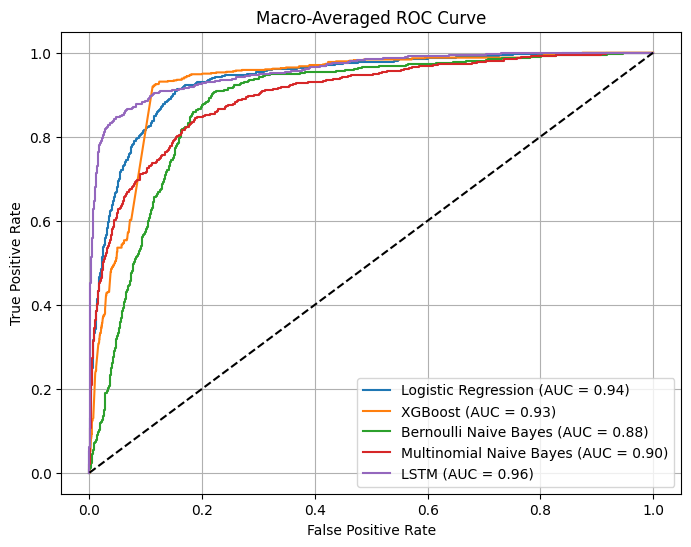

In [43]:
# Roc Curve

# Compute ROC curve for each class separately
fpr_lr, tpr_lr, _ = roc_curve(y_test.ravel(), lr_probs, pos_label=1)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test.ravel(), xgb_probs, pos_label=1)
fpr_nb, tpr_nb, _ = roc_curve(y_test.ravel(), nb_probs, pos_label=1)
fpr_nb_multi, tpr_nb_multi, _ = roc_curve(y_test.ravel(), nb_multi_probs, pos_label=1)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test_n[:, 1], y_pred_nn[:, 1])

# Calculate macro-averaged AUC for multi-class models
roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
roc_auc_nb = auc(fpr_nb, tpr_nb)
roc_auc_nb_multi = auc(fpr_nb_multi, tpr_nb_multi)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# Plot ROC curve graph
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.2f})")
plt.plot(fpr_nb, tpr_nb, label=f"Bernoulli Naive Bayes (AUC = {roc_auc_nb:.2f})")
plt.plot(fpr_nb_multi, tpr_nb_multi, label=f"Multinomial Naive Bayes (AUC = {roc_auc_nb_multi:.2f})")
plt.plot(fpr_lstm, tpr_lstm, label=f"LSTM (AUC = {roc_auc_lstm:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-Averaged ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()